### Train ML model using MOM6 data

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
#from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state 
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

import optax
import xbatcher
import fsspec

#import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

from datetime import datetime

import xgcm

import sys

sys.path.append('../../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day/'

In [3]:
Lsel = '400'

ds = xr.open_zarr(f'{data_bucket}ml_data_'+Lsel+'km.zarr').sel(yh=slice(float(Lsel), 1600-float(Lsel)))

In [10]:
import datasets

In [7]:
Lsel = '100'
MOM6_P2L_data = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_'+Lsel+'km.zarr'

In [8]:
ds_long = xr.open_zarr(MOM6_P2L_data)

In [11]:
temp = datasets.MOM6_transformer(MOM6_P2L_data, Lsel)

In [13]:
temp.read_dataset()

Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr


In [14]:
temp.dataset

<xarray.Dataset>
Dimensions:    (Time: 7200, zl: 2, yh: 80, xh: 60, zi: 3)
Coordinates:
  * Time       (Time) object 0001-01-11 00:00:00 ... 0198-02-16 00:00:00
  * xh         (xh) float64 10.0 30.0 50.0 70.0 ... 1.15e+03 1.17e+03 1.19e+03
  * yh         (yh) float64 10.0 30.0 50.0 70.0 ... 1.55e+03 1.57e+03 1.59e+03
  * zi         (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl         (zl) float64 1.031e+03 1.033e+03
Data variables: (12/26)
    dudx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    dudy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    dvdx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    dvdy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    e          (Time, zi, yh, xh) float32 dask.array<chunksize=(72, 3, 80, 60), meta=np.ndarray>
    h          (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    ...         ...
    vh         (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    vh_bar     (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    vh_sg      (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    vv         (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    vv_bar     (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>
    vv_sg      (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 80, 60), meta=np.ndarray>

In [55]:
try:
    os.mkdir('figures/'+Lsel+'km')
except:
    pass

In [56]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy']

In [57]:
def ML_vars(ds_L, choice=0):
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    #ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    #choice = 0 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    return ds_test

In [58]:
ds_ML = ML_vars(ds, choice=1)

In [59]:
# norms 
ds_std = ds_ML.std(['Time','xh','yh']).load()

In [60]:
ds_norm = ds_ML/ds_std

In [61]:
ds_train = ds_norm.isel(Time=slice(0, 330)).stack(points=('Time','xh','yh'))
ds_test = ds_norm.isel(Time=slice(330,None)).stack(points=('Time','xh','yh'))

In [62]:
npoints_train = len(ds_train['Sfnx'])
npoints_test = len(ds_test['Sfnx'])
print(npoints_train, npoints_test)

49500 4500


In [63]:
%%time

ds_train.load();
ds_test.load();

CPU times: user 134 ms, sys: 20.5 ms, total: 154 ms
Wall time: 336 ms


In [64]:
ds_train_randomized = ds_train.isel(points=np.random.choice(npoints_train, size=npoints_train, replace=False))
ds_test_randomized  = ds_test.isel(points=np.random.choice(npoints_test, size=npoints_test, replace=False))

In [65]:
bgen_train = xbatcher.BatchGenerator(ds = ds_train_randomized, 
                               input_dims={},
                               batch_dims={'points': int(756000/2)}   )

bgen_test = xbatcher.BatchGenerator(ds = ds_test_randomized, 
                               input_dims={},
                               batch_dims={'points': int(756000/2)}   )

ValueError: input sample length must be less than or equal to the dimension length, but the sample length of 378000 is greater than the dimension length of 49500 for points

In [66]:
bgen_train = xbatcher.BatchGenerator(ds = ds_train_randomized, 
                               input_dims={},
                               batch_dims={'points': int(4500)}   )

bgen_test = xbatcher.BatchGenerator(ds = ds_test_randomized, 
                               input_dims={},
                               batch_dims={'points': int(4500)}   )

In [67]:
len(bgen_train), len(bgen_test)

(11, 1)

In [68]:
size_name = 'small'
layer_sizes = [24, 24, 2]

#size_name = 'medium'
#layer_sizes = [32, 32, 2]

#size_name = 'large'
#layer_sizes = [64, 64, 2]


model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )

In [69]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(param_count)

818


In [70]:
# setup loss function
loss_grad_fn = jax.value_and_grad(ml_hf.mse) # more convenient function as it outputs both value and gradient.

In [71]:
design_name = 'first_order'
res_name = Lsel

In [72]:
# Setup optimizer 

learning_rate = .01 # .05 for 100, .01 for 100, .05 for 100
# Maybe useful if wanting to set learning rates manually: https://github.com/deepmind/optax/issues/4

# Initialize optimizer
tx = optax.adam(learning_rate=learning_rate)

# Define training state 
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

In [73]:
num_epochs = 201

In [74]:
# initialize for wandb
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [75]:
run = wandb.init(
    # Set the project where this run will be logged
    project="pointwise_nov_2023_MOM6",
    # Track hyperparameters and run metadata
    name=design_name + ", "+ res_name + ", " + size_name,
    config={
        "scale": Lsel,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "layer_sizes": layer_sizes,
        "inputs": input_channels, 
        "outputs": output_channels,
        "date": str(datetime.now()),
    })

test_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.00833
train_loss,0.0086


In [76]:
# to track model
train_loss = np.array([])
test_loss = np.array([])

In [77]:
%%time
# Main training loop


for i in range(num_epochs):
    n=0
    
    loss_temp = np.array([]) # temp array to save batches
    for batch in bgen_train:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_train = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_train = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        
        # Compute gradients and update parameters and optimizer state 
        loss_val, grads = loss_grad_fn(state.params, state.apply_fn, X_train, y_train)
        state = state.apply_gradients(grads=grads)
        
        loss_temp = np.append(loss_temp, loss_val)
    
    
    train_loss = np.append(train_loss, np.mean(loss_temp))
    
    test_loss_temp = np.array([])
    for batch in bgen_test:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_test = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_test = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        test_loss_temp = np.append(test_loss_temp, ml_hf.mse(state.params, state.apply_fn, X_test, y_test))
    
    test_loss = np.append(test_loss, np.mean(test_loss_temp))
    
    wandb.log({'train_loss': train_loss[-1], 'test_loss': test_loss[-1]})
    
    if i % 10  == 0:
        print(f'Train loss step {i}: ', train_loss[-1], f'test loss:', test_loss[-1])
        

Train loss step 0:  0.9515563737262379 test loss: 0.633665144443512
Train loss step 10:  0.4440972723744132 test loss: 0.42660242319107056
Train loss step 20:  0.4343926689841531 test loss: 0.41556522250175476
Train loss step 30:  0.4290214614434676 test loss: 0.4115806818008423
Train loss step 40:  0.425079036842693 test loss: 0.40858837962150574
Train loss step 50:  0.42233264446258545 test loss: 0.40617892146110535
Train loss step 60:  0.420666366815567 test loss: 0.40466564893722534
Train loss step 70:  0.41865995255383576 test loss: 0.40445631742477417
Train loss step 80:  0.4167842377315868 test loss: 0.40296074748039246
Train loss step 90:  0.4151924117044969 test loss: 0.40196695923805237
Train loss step 100:  0.4132863933389837 test loss: 0.4005316197872162
Train loss step 110:  0.41046456586230884 test loss: 0.39830663800239563
Train loss step 120:  0.40720723975788464 test loss: 0.39620116353034973
Train loss step 130:  0.40504223108291626 test loss: 0.3952951431274414
Train

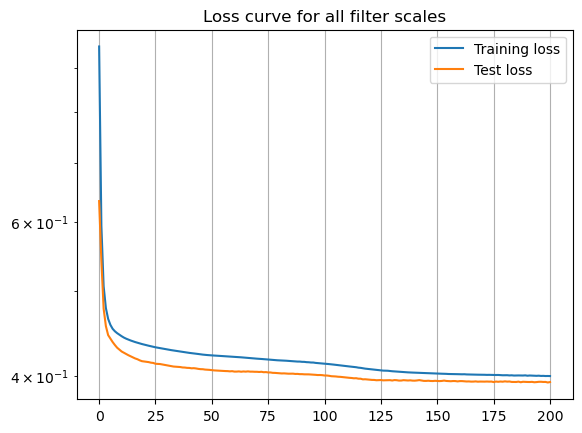

In [79]:
fig, ax = plt.subplots()

ax.plot(train_loss, label='Training loss')
ax.plot(test_loss, label='Test loss')

ax.set_title('Loss curve for all filter scales')
ax.grid()
ax.set_yscale('log')
ax.legend()

fig.savefig('figures/'+res_name+'_km'+'/loss_curve_'+size_name+'.png')

run.log({"loss_curve": wandb.Image(fig)})